#### Imports and Data Loading

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import us
import seaborn as sns
from linearmodels.iv import IV2SLS

In [12]:
# set the path to the directory containing the folder 'DATA'
path_start = '/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/'

In [75]:
# 1) from create.do:
indshares = pd.read_stata(path_start + 'indshares.dta')
otheroutcomes = pd.read_stata(path_start + 'otheroutcomes.dta')

## instruments
for lag in [0, 10, 20, 30, 40]:
    globals()[f'spred{lag}'] = pd.read_stata(f"{path_start}spred{lag}.dta")

In [14]:
# 2) from create_bpl.do (same as create.do, but uses place of residence in the 
# previous year instead of current year for Table A10):
otheroutcomes_bpl = pd.read_stata(path_start + 'otheroutcomes_bpl.dta')
spred10_bpl = pd.read_stata(path_start + 'spred10_bpl.dta')

In [5]:
# 3) from createBEA.do: 
gdpcomp = pd.read_stata(path_start + 'gdpandcomp.dta')

In [17]:
# 4) ACS
ACS = pd.read_stata(path_start + 'ACS.dta')

#### Data Cleaning

In [35]:
# to map from states to fips code
state_name_to_fips = {state.name: state.fips for state in us.states.STATES + [us.states.DC]}

In [9]:
# verify 'year' is int and convert 'stfips'
for df_name, df in zip(["spred10", "spred20", "spred30", "spred40", "spred0", "gdpcomp", "otheroutcomes_bpl"], 
                        [spred10, spred20, spred30, spred40, spred0, gdpcomp, otheroutcomes_bpl]):
    df['year'] = df['year'].astype(int)

    # mapping only if stfips is stored as strings (state names)
    if df['stfips'].dtype == 'object' or df['stfips'].dtype.name == 'category':
        df['stfips'] = df['stfips'].map(state_name_to_fips)

    # drop NaN values before converting to integers
    df.dropna(subset=['stfips'], inplace=True)

    df['stfips'] = df['stfips'].astype(int)

    print(f"Cleaned {df_name}: Unique stfips values now:", df['stfips'].unique()[:10])

Cleaned spred10: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred20: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred30: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred40: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred0: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned gdpcomp: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned otheroutcomes_bpl: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]


In [19]:
#Compensation_st = total state labor compensation in year t using BEA's measure
#of total labor compensation (labor earnings plus non-cash compensation)
#GDP_st / Hours_st = GDP_st / Comp_st * Comp_st / Hours_st

#GDP_st / N_st = GDP_st / Hours_st * Hours_st / L_st * L_st / N_st
#L is level of employment for workers aged 20+

In [20]:
#equation 1 

#ln(GDP_(st + 10) / N_(st + 10)) - ln(GDP_st / N_st) 
# = 
# beta * [ln(A_(st + 10) / N_(st + 10)) - ln(A_st / N_st)] + X'_st * delta_t + gamma_t 
#+ (epsilon_(st+10) - epsilon_st)

#A_st is the number of individuals aged 60 and older in state s and year t
#N_st is the state population 20 and older in year t
#X_st is a set of time-varying control variables whose influence
#gamma_t is time fixed effects
#epsilon_st is state output shocks

In [21]:
#equation 1, revised based on available data I see

#ln(GDP_(st + 10) / N_(st + 10)) - ln(GDP_st / N_st) 
# = 
# beta * [ln(A_(st + 10) / N_(st + 10)) - ln(A_st / N_st)] + (epsilon_(st+10) - epsilon_st)

#A_st is the number of individuals aged 60 and older in state s and year t
#N_st is the state population 20 and older in year t
#epsilon_st is state output shocks

#### Figure 1: Fraction of US Pop. Age 60+

/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_50996/2238013146.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_pop = (ACS.dropna(subset=['age_group'])


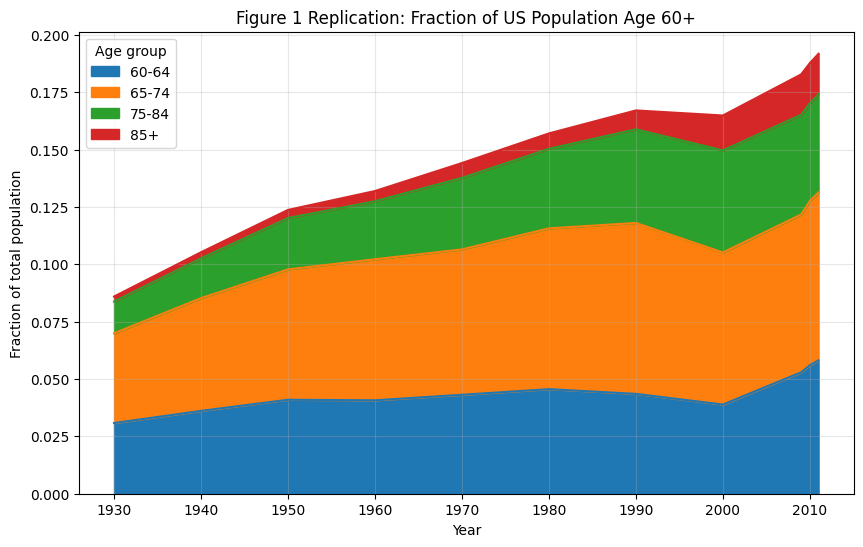

In [21]:
# four groups: 60-64, 65-74, 75-84, 85+

# clean types
ACS['age']   = pd.to_numeric(ACS['age'], errors='coerce')
ACS['perwt'] = pd.to_numeric(ACS['perwt'], errors='coerce')
ACS['year']  = pd.to_numeric(ACS['year'], errors='coerce')

# keep plausible ages and nonmissing weights/years
ACS = ACS[ACS['age'].between(0, 115) & ACS['perwt'].notna() & ACS['year'].notna()]

# define age groups (left-closed, right-open: [60,65), [65,75), [75,85), [85, 200) )
bins   = [60, 65, 75, 85, 200]
labels = ['60-64', '65-74', '75-84', '85+']
ACS['age_group'] = pd.cut(ACS['age'], bins=bins, labels=labels, right=False)

# weighted totals per year
total_pop = ACS.groupby('year', as_index=False)['perwt'].sum().rename(columns={'perwt': 'total_perwt'})

# weighted counts by age group per year
age_group_pop = (ACS.dropna(subset=['age_group'])
                   .groupby(['year','age_group'], as_index=False)['perwt'].sum())

# fractions = group weight / total weight
age_group_frac = (age_group_pop
                  .merge(total_pop, on='year')
                  .assign(frac=lambda d: d['perwt'] / d['total_perwt'])
                  .pivot(index='year', columns='age_group', values='frac')
                  .sort_index())

plt.figure(figsize=(10,6))
age_group_frac.fillna(0)[labels].plot.area(ax=plt.gca())
plt.title('Figure 1 Replication: Fraction of US Population Age 60+')
plt.xlabel('Year')
plt.ylabel('Fraction of total population')
plt.grid(alpha=0.3)
plt.legend(title='Age group')
plt.show()


#### Figure 2: Relationships Between Aging, Predicted Aging, and Economic Growth

##### Figure 2: Panel A. Aging and Per Capita GDP Growth

/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_50996/2324010284.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = (acs_sub.groupby(['statefip','year'])
/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_50996/2324010284.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({
/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_50996/2324010284.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future 

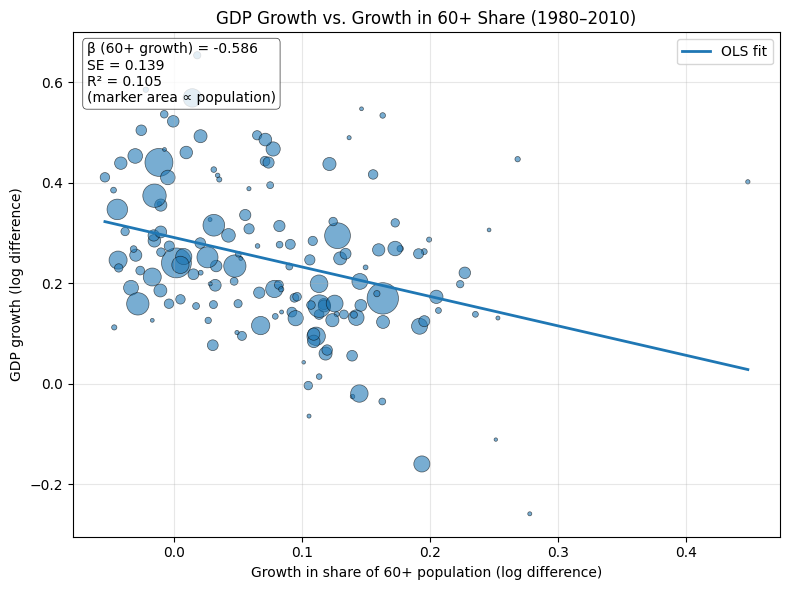

In [ ]:
# ACS has columns: year, statefip, age, perwt

# Restrict to the years of interest
acs_sub = ACS[ACS['year'].isin([1980,1990,2000,2010])].copy()

# Compute total weighted population and 60+ population by state-year
acs_sub['is60plus'] = (acs_sub['age'] >= 60).astype(int)

agg = (acs_sub.groupby(['statefip','year'])
                 .apply(lambda d: pd.Series({
                     'pop_total': d['perwt'].sum(),
                     'pop_60plus': d.loc[d['is60plus']==1,'perwt'].sum()
                 }))
                 .reset_index())

# Share of 60+ population
agg['share60plus'] = agg['pop_60plus'] / agg['pop_total']

# Log of the share
agg['log_share60plus'] = np.log(agg['share60plus'])

# Sort and compute decadal growth (log difference)
agg = agg.sort_values(['statefip','year'])
agg['growth_share60plus'] = agg.groupby('statefip')['log_share60plus'].diff()

# Convert to % growth if you like
agg['growth_share60plus_pct'] = agg['growth_share60plus'] * 100

# Keep only rows where growth is defined (1990, 2000, 2010)
growth = agg.dropna(subset=['growth_share60plus'])

# Map and convert to integer
growth['stfips'] = growth['statefip'].map(state_name_to_fips).astype(int)

# Drop the old name column if you don’t need it
growth = growth.drop(columns=['statefip'])

# Reorder so stfips is first
cols = ['stfips'] + [c for c in growth.columns if c != 'stfips']
growth = growth[cols]


# Filter to the years of interest
gdp_sub = gdpcomp[gdpcomp['year'].isin([1980,1990,2000,2010])].copy()

# Sort by state and year
gdp_sub = gdp_sub.sort_values(['stfips','year'])

# Compute log GDP
gdp_sub['log_gdp'] = np.log(gdp_sub['gdp'])

# Compute decade-to-decade growth
gdp_sub['gdp_growth'] = gdp_sub.groupby('stfips')['log_gdp'].diff()

# Sort for lagged calculations
gdp_sub = gdp_sub.sort_values(['stfips','year']).copy()

# Log of GDP
gdp_sub['log_gdp'] = np.log(gdp_sub['gdp'])

# Decadal growth = log difference
gdp_sub['gdp_growth'] = gdp_sub.groupby('stfips')['log_gdp'].diff()

# Keep only rows where growth is defined (1990, 2000, 2010)
gdp_growth = gdp_sub.dropna(subset=['gdp_growth'])


# Select only the columns you want from gdp_growth
gdp_sel = gdp_growth[['stfips', 'year', 'gdp_growth']].copy()

# Merge with growth on stfips and year
merged = growth.merge(gdp_sel, on=['stfips','year'], how='inner')
merged


# --- OLS ---
X = sm.add_constant(merged['growth_share60plus'])
y = merged['gdp_growth']
model = sm.OLS(y, X).fit()

beta = model.params['growth_share60plus']
se   = model.bse['growth_share60plus']
r2   = model.rsquared

# --- Point sizes (area) proportional to population ---
# Matplotlib's 's' is marker area (points^2). We scale to keep sizes readable.
pop = merged['pop_total']  # from your 'growth' part of the merge
# Make area roughly proportional to pop but not overpowering:
size_scale = 50 / pop.median()  # adjust this constant to taste
sizes = np.clip(pop * size_scale, 5, 800)  # clamp to avoid extremes

# --- Plot ---
plt.figure(figsize=(8,6))

plt.scatter(
    merged['growth_share60plus'],
    merged['gdp_growth'],
    s=sizes,
    alpha=0.6,
    edgecolor='k',
    linewidth=0.5
)

# Fitted line
x_grid = np.linspace(merged['growth_share60plus'].min(),
                     merged['growth_share60plus'].max(), 200)
y_grid = model.params['const'] + beta * x_grid
plt.plot(x_grid, y_grid, linewidth=2, label='OLS fit')

# Labels
plt.xlabel("Growth in share of 60+ population (log difference)")
plt.ylabel("GDP growth (log difference)")
plt.title("GDP Growth vs. Growth in 60+ Share (1980–2010)")

# Annotation: coefficient, SE, R²
textstr = (f"β (60+ growth) = {beta:.3f}\n")
# Place in upper left inside axes
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
         va='top', ha='left', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, lw=0.5))

plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


##### Figure 2: Panel B. Predicted Aging and Observed Aging

Number of states included: 51
          stfips  pred_growth  real_growth
0     Washington    39.102131    14.312609
1  West Virginia    15.198840     1.121550
2        Georgia    42.134553    20.578736
3        Alabama    24.121779     9.852573
4       New York    13.700506     0.705481


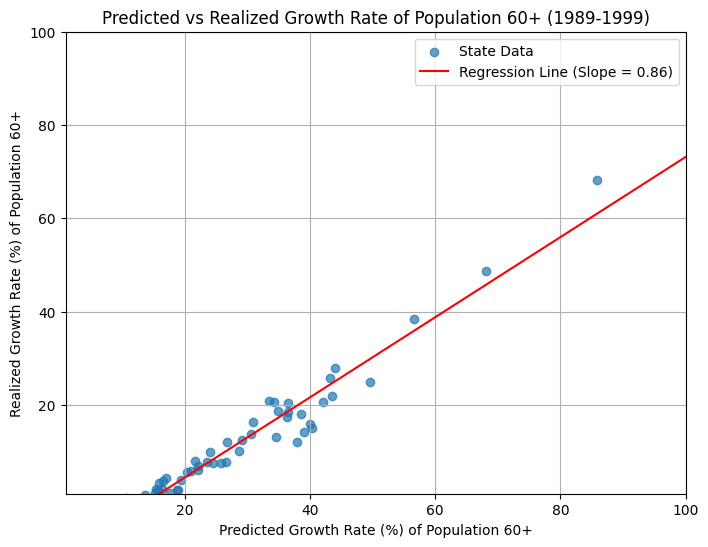

In [ ]:
#panel B: predicted aging and observed aging
#y: Growth rate in % of pop. above 60+
#x: Predicted growth rate in % of pop. 60+
#slope = 0.827

# Use only valid years based on lag structure
valid_years = [1989, 1999]  # Exclude 2009 for spred10

spred10_filtered = spred10[spred10['year'].isin(valid_years)].copy()
spred0_filtered = spred0[spred0['year'].isin(valid_years)].copy()

# Compute the population aged 60+ for predictions and realizations
spred10_filtered['pop_60_plus'] = spred10_filtered[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)
spred0_filtered['pop_60_plus'] = spred0_filtered[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

# Identify valid states (only those with 2 years)
valid_states = set(spred10_filtered['stfips'].unique()) & set(spred0_filtered['stfips'].unique())

growth_rates = []
for state in valid_states:
    pred_state = spred10_filtered[spred10_filtered['stfips'] == state].sort_values('year')
    real_state = spred0_filtered[spred0_filtered['stfips'] == state].sort_values('year')
    
    if len(pred_state) == 2 and len(real_state) == 2:  # Only compare two valid years
        initial_pred = pred_state['pop_60_plus'].iloc[0]
        final_pred = pred_state['pop_60_plus'].iloc[-1]
        initial_real = real_state['pop_60_plus'].iloc[0]
        final_real = real_state['pop_60_plus'].iloc[-1]
        
        # Compute percentage growth
        pred_growth = ((final_pred - initial_pred) / initial_pred) * 100 if initial_pred > 0 else None
        real_growth = ((final_real - initial_real) / initial_real) * 100 if initial_real > 0 else None

        if pred_growth is not None and real_growth is not None:
            growth_rates.append({'stfips': state, 'pred_growth': pred_growth, 'real_growth': real_growth})

growth = pd.DataFrame(growth_rates)

print(f"Number of states included: {len(growth)}")

if not growth.empty:
    X = growth[['pred_growth']].values 
    y = growth['real_growth'].values  

    reg = LinearRegression().fit(X, y) 
    slope = reg.coef_[0] 

    x_range = np.linspace(1, 100, 100).reshape(-1, 1)
    y_pred = reg.predict(x_range)

    plt.figure(figsize=(8, 6))
    plt.scatter(growth['pred_growth'], growth['real_growth'], alpha=0.7, label="State Data")
    plt.plot(x_range, y_pred, color='red', linestyle='-', label=f"Regression Line (Slope = {slope:.2f})")

    plt.xlim(1, 100)  # Restrict x-axis from 1% to 100%
    plt.ylim(1, 100)  # Restrict y-axis from 1% to 100%
    plt.xlabel("Predicted Growth Rate (%) of Population 60+")
    plt.ylabel("Realized Growth Rate (%) of Population 60+")
    plt.title("Predicted vs Realized Growth Rate of Population 60+ (1989-1999)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Warning: No valid states available. Check data consistency.")

##### Figure 2: Panel C. Predicted Aging and Per Capita GDP Growth

#### Table 1: Main Results by Instrument Lag

Table 1 Notes: Number of observations = 153 in all regressions. Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st . Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities,
wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year.

In [ ]:
# Define instrument lags and corresponding datasets
lagged_instruments = {
    10: spred10,
    20: spred20,
    30: spred30,
    40: spred40
}

# Define full set of years
years = [1969, 1979, 1989, 1999, 2009]

# Drop years for each lagged instrument (as per dataset construction)
drop_years = {
    10: [2009],
    20: [1999, 2009],
    30: [1989, 1999, 2009],
    40: [1979, 1989, 1999, 2009]
}

# Prepare results storage
results_table = pd.DataFrame(index=['Reduced Form', 'First Stage', 'IV Estimate'], columns=[10, 20, 30, 40])

# Loop through each lagged instrument
for lag, spred in lagged_instruments.items():
    print(f"Running regressions for {lag}-year lagged instrument...")

    # Define valid years based on known zero patterns
    valid_years = [year for year in years if year not in drop_years[lag]]

    # Filter datasets for relevant years
    spred_filtered = spred[spred['year'].isin(valid_years)].copy()
    spred0_filtered = spred0[spred0['year'].isin(valid_years)].copy()
    gdp_filtered = gdpcomp[gdpcomp['year'].isin(valid_years)].copy()

    # Compute the predicted number of individuals aged 60+ (A^)
    pred_columns = [f'pred{lag}num6', f'pred{lag}num7', f'pred{lag}num8', f'pred{lag}num9']
    spred_filtered['A_hat'] = spred_filtered[pred_columns].sum(axis=1)

    # Compute the realized number of individuals aged 60+ (A)
    real_columns = ['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']
    spred0_filtered['A_real'] = spred0_filtered[real_columns].sum(axis=1)

    # Compute per capita GDP
    gdp_filtered['per_capita_gdp'] = gdp_filtered['gdp'] / gdp_filtered['comp']

    # Merge datasets by 'stfips' and 'year'
    merged = pd.merge(spred_filtered[['stfips', 'year', 'A_hat']],
                         gdp_filtered[['stfips', 'year', 'per_capita_gdp', 'comp']],
                         on=['stfips', 'year'])
    
    merged = pd.merge(merged,
                         spred0_filtered[['stfips', 'year', 'A_real']],
                         on=['stfips', 'year'])

    # Compute log differences for all (t, t+10) pairs
    growth_data = []
    for t in valid_years:
        t10 = t + 10
        if t10 not in valid_years:
            continue  # Skip if t+10 is outside valid years

        df_t = merged[merged['year'] == t].set_index('stfips')
        df_t10 = merged[merged['year'] == t10].set_index('stfips')

        # Ensure only states present in both periods are kept
        valid_states = df_t.index.intersection(df_t10.index)
        df_t = df_t.loc[valid_states]
        df_t10 = df_t10.loc[valid_states]

        # Compute changes in log values
        gdp_growth = np.log(df_t10['per_capita_gdp']) - np.log(df_t['per_capita_gdp'])
        pred_pop_share_t = df_t['A_hat'] / df_t['comp']
        pred_pop_share_t10 = df_t10['A_hat'] / df_t10['comp']
        pred_pop_growth = np.log(pred_pop_share_t10) - np.log(pred_pop_share_t)
        real_pop_share_t = df_t['A_real'] / df_t['comp']
        real_pop_share_t10 = df_t10['A_real'] / df_t10['comp']
        real_pop_growth = np.log(real_pop_share_t10) - np.log(real_pop_share_t)

        # Store values for regression
        for state in valid_states:
            growth_data.append({
                'stfips': state,
                'gdp_growth': gdp_growth[state],
                'pred_pop_growth': pred_pop_growth[state],
                'real_pop_growth': real_pop_growth[state]
            })

    # Convert to DataFrame
    growth = pd.DataFrame(growth_data).dropna()

    # Ensure we have data for regression
    if growth.empty:
        print(f"Skipping {lag}-year instrument due to insufficient data.")
        continue

    # Panel A: Reduced Form Estimate
    X_reduced = sm.add_constant(growth['gdp_growth'])
    y_reduced = growth['pred_pop_growth']
    reduced_form = sm.OLS(y_reduced, X_reduced).fit()
    results_table.loc['Reduced Form', lag] = reduced_form.params[1]

    # Panel B: First Stage Estimate
    X_first_stage = sm.add_constant(growth['real_pop_growth'])
    y_first_stage = growth['pred_pop_growth']
    first_stage = sm.OLS(y_first_stage, X_first_stage).fit()
    results_table.loc['First Stage', lag] = first_stage.params[1]

    # Panel C: IV Estimate
    iv_model = IV2SLS(
        dependent=growth['real_pop_growth'],  
        exog=sm.add_constant(np.ones(len(growth))),  
        endog=growth['gdp_growth'],  
        instruments=growth['pred_pop_growth']  
    ).fit()
    results_table.loc['IV Estimate', lag] = iv_model.params[1]

display(results_table)

# Print results for verification
print("IV Regression Results:")
print(results_table)

Running regressions for 10-year lagged instrument...
Running regressions for 20-year lagged instrument...
Running regressions for 30-year lagged instrument...
Running regressions for 40-year lagged instrument...
Skipping 40-year instrument due to insufficient data.


/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_6325/3026372446.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_table.loc['Reduced Form', lag] = reduced_form.params[1]
/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_6325/3026372446.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_table.loc['First Stage', lag] = first_stage.params[1]
/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_6325/3026372446.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

,10,20,30,40
Reduced Form,-0.397104,1.3456,-0.19567,NaN
First Stage,1.178224,1.144549,0.542883,NaN
IV Estimate,-35.442018,11.772689,-17.565589,NaN


IV Regression Results:
                     10         20         30   40
Reduced Form  -0.397104     1.3456   -0.19567  NaN
First Stage    1.178224   1.144549   0.542883  NaN
IV Estimate  -35.442018  11.772689 -17.565589  NaN


#### Table 2: Decomposing Main Effect into Labor Productivity and Employment

In [ ]:
#table 2 - decomposing main effect
#instrument length: 10 year lag
#four cols
#∆ln(A/N) = ∆ln(GDP/N), ∆ln(GDP/hours), ∆ln(H/L), ∆ln(L/N)
# Define valid years (drop 2009 for 10-year lag)
valid_years = [1999]

# Filter datasets
spred_filtered = spred10[spred10['year'].isin(valid_years)].copy()
spred0_filtered = spred0[spred0['year'].isin(valid_years)].copy()
gdp_filtered = gdpcomp[gdpcomp['year'].isin(valid_years)].copy()
earnings_filtered = otheroutcomes_bpl[otheroutcomes_bpl['year'].isin(valid_years)].copy()

# Compute predicted number of 60+ individuals (A^)
spred_filtered['A_hat'] = spred_filtered[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)

# Compute realized number of 60+ individuals (A)
spred0_filtered['A_real'] = spred0_filtered[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

# Compute per capita GDP
gdp_filtered['per_capita_gdp'] = gdp_filtered['gdp'] / gdp_filtered['comp']

# Merge datasets by 'stfips' and 'year'
merged = pd.merge(spred_filtered[['stfips', 'year', 'A_hat']],
                     gdp_filtered[['stfips', 'year', 'per_capita_gdp', 'comp', 'gdp']],
                     on=['stfips', 'year'])

merged = pd.merge(merged, spred0_filtered[['stfips', 'year', 'A_real']], on=['stfips', 'year'])
merged = pd.merge(merged, earnings_filtered[['stfips', 'year', 'earn', 'tothrs2', 'work']], on=['stfips', 'year'])
merged = pd.merge(merged, otheroutcomes_bpl[['stfips', 'year', 'earn', 'tothrs2', 'work']], on=['stfips', 'year'], how='inner')

merged['tothrs2'] = merged['tothrs2_x']  # or merged['tothrs2_y']
merged['work'] = merged['work_x']
merged['earn'] = merged['earn_x']  # or merged['tothrs2_y'] 

merged.drop(columns=['tothrs2_x', 'tothrs2_y'], inplace=True)
merged.drop(columns=['work_x', 'work_y'], inplace=True)
merged.drop(columns=['earn_x', 'earn_y'], inplace=True)

# Drop missing values only if the columns exist
drop_cols = [col for col in ['A_hat', 'A_real', 'gdp', 'earn', 'tothrs2', 'work'] if col in merged.columns]
merged.dropna(subset=drop_cols, inplace=True)

print("Size of merged after dropping missing values:", merged.shape)

Size of merged_df after dropping missing values: (51, 10)


In [ ]:
print("Columns in df_t:", df_t.columns)
print("Columns in df_t10:", df_t10.columns)

Columns in df_t: Index(['year', 'A_hat', 'per_capita_gdp', 'comp', 'A_real'], dtype='object')
Columns in df_t10: Index(['year', 'A_hat', 'per_capita_gdp', 'comp', 'A_real'], dtype='object')


In [ ]:
# Compute log differences for (t, t+10) pairs
growth_data = []
for t in [1999]:
    t10 = t + 10

    df_t = merged[merged['year'] == t].set_index('stfips')
    df_t10 = merged[merged['year'] == t10].set_index('stfips')

    # Ensure only states present in both periods are kept
    valid_states = df_t.index.intersection(df_t10.index)
    df_t = df_t.loc[valid_states]
    df_t10 = df_t10.loc[valid_states]

    # Compute changes in log values
    gdp_growth = np.log(df_t10['per_capita_gdp']) - np.log(df_t['per_capita_gdp'])
    pred_pop_share_t = df_t['A_hat'] / df_t['comp']
    pred_pop_share_t10 = df_t10['A_hat'] / df_t10['comp']
    pred_pop_growth = np.log(pred_pop_share_t10) - np.log(pred_pop_share_t)
    real_pop_share_t = df_t['A_real'] / df_t['comp']
    real_pop_share_t10 = df_t10['A_real'] / df_t10['comp']
    real_pop_growth = np.log(real_pop_share_t10) - np.log(real_pop_share_t)

    # Compute decomposition components using tothrs2 and work
    gdp_per_hour_growth = np.log(df_t10['gdp'] / df_t10['tothrs2']) - np.log(df_t['gdp'] / df_t['tothrs2'])
    hours_per_worker_growth = np.log(df_t10['tothrs2'] / df_t10['work']) - np.log(df_t['tothrs2'] / df_t['work'])
    employment_rate_growth = np.log(df_t10['work'] / df_t10['comp']) - np.log(df_t['work'] / df_t['comp'])
    earnings_per_hour_growth = np.log(df_t10['earn'] / df_t10['tothrs2']) - np.log(df_t['earn'] / df_t['tothrs2'])

    # Store values for regression
    for state in valid_states:
        growth_data.append({
            'stfips': state,
            'gdp_growth': gdp_growth[state],
            'pred_pop_growth': pred_pop_growth[state],
            'real_pop_growth': real_pop_growth[state],
            'gdp_per_hour_growth': gdp_per_hour_growth[state],
            'hours_per_worker_growth': hours_per_worker_growth[state],
            'employment_rate_growth': employment_rate_growth[state],
            'earnings_per_hour_growth': earnings_per_hour_growth[state]
        })

# Convert to DataFrame
growth = pd.DataFrame(growth_data).dropna()

# Ensure we have data for regression
if growth.empty:
    print("Skipping 10-year decomposition due to insufficient data.")
else:
    results_table = pd.DataFrame(index=['IV Estimate', 'Decomposition: GDP/Hours', 'Decomposition: H/L', 'Decomposition: L/N', 'Decomposition: Earnings/Hours'], columns=['10-Year Lag'])

    # IV Estimate: ∆ln(A / N) = ∆ln(GDP / N)
    iv_model = IV2SLS(
        dependent=growth['real_pop_growth'],  
        exog=sm.add_constant(np.ones(len(growth))),  
        endog=growth['gdp_growth'],  
        instruments=growth['pred_pop_growth']  
    ).fit()
    results_table.loc['IV Estimate', '10-Year Lag'] = iv_model.params[1]

    # Decomposition regressions
    for comp, label in zip(['gdp_per_hour_growth', 'hours_per_worker_growth', 'employment_rate_growth', 'earnings_per_hour_growth'],
                           ['Decomposition: GDP/Hours', 'Decomposition: H/L', 'Decomposition: L/N', 'Decomposition: Earnings/Hours']):
        comp_model = IV2SLS(
            dependent=growth['real_pop_growth'],  
            exog=sm.add_constant(np.ones(len(growth))),  
            endog=growth[comp],  
            instruments=growth['pred_pop_growth']  
        ).fit()
        results_table.loc[label, '10-Year Lag'] = comp_model.params[1]

    display(results_table)

    # Print results for verification
    print("Decomposition Table (10-Year Lag):")
    print(results_table)

Skipping 10-year decomposition due to insufficient data.


Table 2 Notes: Number of observations = 153 in all regressions. Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st . The coefficients presented in columns 2, 3, and 4 mechanically sum to the main effect presented in column 1. Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS. Notation: L = number of workers; Hours = total number of hours worked

In [ ]:
merged

,stfips,year,A_hat,per_capita_gdp,comp,gdp,A_real,tothrs2,work,earn
0,1,1999,9.643083e+05,1.674045,66951.0,112079.0,770395.0,3.967632e+09,2112515.0,5.817407e+10
1,2,1999,1.000943e+05,1.873979,12728.0,23852.0,51677.0,6.123156e+08,337603.0,1.050963e+10
2,4,1999,1.049669e+06,1.826188,82618.0,150876.0,871764.0,4.590817e+09,2452022.0,7.357752e+10
3,5,1999,5.926632e+05,1.807481,36651.0,66246.0,492187.0,2.405768e+09,1282236.0,3.167985e+10
4,6,1999,6.173818e+06,1.799320,673505.0,1211851.0,4731023.0,3.027957e+10,16532679.0,5.606264e+11
5,8,1999,7.988389e+05,1.697386,91539.0,155377.0,558744.0,4.514939e+09,2376018.0,7.754216e+10
6,9,1999,7.421372e+05,1.735827,86061.0,149387.0,603008.0,3.391424e+09,1790863.0,7.356907e+10
7,10,1999,1.658795e+05,2.137626,17642.0,37712.0,133269.0,7.683044e+08,409377.0,1.373816e+10
8,11,1999,1.158698e+05,1.322809,42347.0,56017.0,91699.0,5.566512e+08,304030.0,1.186614e+10
9,12,1999,3.837112e+06,1.761666,255755.0,450555.0,3546266.0,1.461574e+10,7732631.0,2.302425e+11


In [ ]:
merged = pd.merge(spred10, gdpcomp, on=['stfips', 'year'], how='inner')
merged = pd.merge(merged, spred0, on=['stfips', 'year'], how='inner')
merged = pd.merge(merged, otheroutcomes_bpl, on=['stfips', 'year'], how='inner')

# Compute predicted number of 60+ individuals (A^)
spred10['A_hat'] = spred10[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)

# Compute realized number of 60+ individuals (A)
spred0['A_real'] = spred0[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

merged = pd.merge(spred10[['stfips', 'year', 'A_hat']], 
                     gdpcomp[['stfips', 'year', 'gdp']], 
                     on=['stfips', 'year'], how='inner')

merged = pd.merge(merged, spred0[['stfips', 'year', 'A_real']], on=['stfips', 'year'], how='inner')
merged = pd.merge(merged, otheroutcomes_bpl[['stfips', 'year', 'earn', 'tothrs2', 'work']], on=['stfips', 'year'], how='inner')

# Drop missing values only after merging
merged.dropna(subset=['A_hat', 'A_real', 'gdp', 'earn', 'tothrs2', 'work'], inplace=True)

print("Size of merged after dropping missing values:", merged.shape)

Size of merged_df after dropping missing values: (102, 8)


#### Table 3: Decomposing the Productivity Effect

In [ ]:
#table 3 - decomposing productivity effect


#two cols
#∆ln(A/N) = ∆ln(GDP/Compensation), ∆ln(Compensation/Hours)

#∆ln(A/N) = ∆ln(GDP/Earnings), ∆ln(Earnings/Hours)

Table 3 Notes: Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st. The coefficients in columns 1 and 2 mechanically add up to the effect estimated in column 2 of Table 2. Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional
services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS with the 10 year lagged instrument. Notation: Hours = total number of hours worked; Earnings = total labor earnings; Compensation = total compensation paid to workers.

#### Table 4: Age-specific Labor Outcomes

In [36]:
#table 4 - age-specific labor outcomes
#three cols for different age groups: 20-39, 40-59, 60+

#∆ln(A/N) = ∆ln(Employment rate)

#∆ln(A/N) = ∆ln(Wage) 

Table 4 Notes: Number of observations = 153. Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st . The outcome is the log of the number of people working scaled by the total number of people (by age group) or the log of the average wage (total earnings scaled by total hours). Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade,finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS with the 10-year lagged instrument

#### Table 5: Testing for Reallocation of Skills

In [35]:
#table 5 - testing for reallocation of skills
#four cols: 1980-2010, 1980-1990, 1990-2000, 2000-2010

#panel 1
#∆ln(A/N) = ∆ln(Population)

#panel 2
#∆ln(A/N) = ∆ln(Fraction with less than 4 years college)


Table 5 Notes: Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy
≡ y s,t+10 − y st . Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public
administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS with the 10-year lagged instrument.

#### Extension: Fuzzy RD

In [ ]:
# 1/3 of Americans claim SS retirements at 62, earliest claiming age
# this tends to coincide with labor force exit

# Define cutoff for treatment
cutoff = 0.20  # 20% predicted share of 60+ population

# Compute predicted and realized share of 60+ population
spred10['A_hat_N'] = spred10[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1) / spred10['pred10all']
spred0['A_real_N'] = spred0[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1) / spred0['pred0all']

# Merge datasets
merged = pd.merge(spred10[['stfips', 'year', 'A_hat_N']], 
                     spred0[['stfips', 'year', 'A_real_N']], 
                     on=['stfips', 'year'], how='inner')

merged = pd.merge(merged, gdpcomp[['stfips', 'year', 'gdp']], on=['stfips', 'year'], how='inner')

# Compute per capita GDP
merged['ln_GDP_N'] = np.log(merged['gdp'])  # Log GDP per capita

# Treatment variable: Did state exceed **realized** 20% aging threshold?
merged['D'] = (merged['A_real_N'] >= cutoff).astype(int)

# Instrument: Did state exceed **predicted** 20% aging threshold?
merged['Z'] = (merged['A_hat_N'] >= cutoff).astype(int)

# Center running variable around cutoff
merged['A_hat_N_centered'] = merged['A_hat_N'] - cutoff

# Drop missing values
merged.dropna(subset=['A_hat_N', 'A_real_N', 'ln_GDP_N', 'Z'], inplace=True)

print("RDD dataset size after filtering:", merged.shape)

RDD dataset size after filtering: (204, 9)


In [ ]:
# First Stage: Predict treatment (D) using the instrument (Z)
X_fs = sm.add_constant(merged[['Z', 'A_hat_N_centered']])  # Instrument and running variable
first_stage = sm.OLS(merged['D'], X_fs).fit()
merged['D_hat'] = first_stage.predict(X_fs)  # Fitted values for treatment

print(first_stage.summary())  

                            OLS Regression Results                            
Dep. Variable:                      D   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     10.76
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           3.63e-05
Time:                        20:50:37   Log-Likelihood:                 83.647
No. Observations:                 204   AIC:                            -161.3
Df Residuals:                     201   BIC:                            -151.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0580      0.042  

In [ ]:
# Second Stage: Estimate the effect of predicted treatment on GDP per capita
iv_model = IV2SLS(
    dependent=merged['ln_GDP_N'],
    exog=sm.add_constant(merged[['A_hat_N_centered']]),  # Running variable (controls)
    endog=merged['D'],  # Actual treatment
    instruments=merged['Z']  # Instrument (discontinuity in predicted aging)
).fit()

print("Fuzzy RDD Results for Log Per Capita GDP:")
print(iv_model.summary)

Fuzzy RDD Results for Log Per Capita GDP:
                          IV-2SLS Estimation Summary                          
Dep. Variable:               ln_GDP_N   R-squared:                      0.0573
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0480
No. Observations:                 204   F-statistic:                    24.080
Date:                Wed, Aug 20 2025   P-value (F-stat)                0.0000
Time:                        20:50:40   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                9.9947     0.1691     59.105     0.0000      9.663

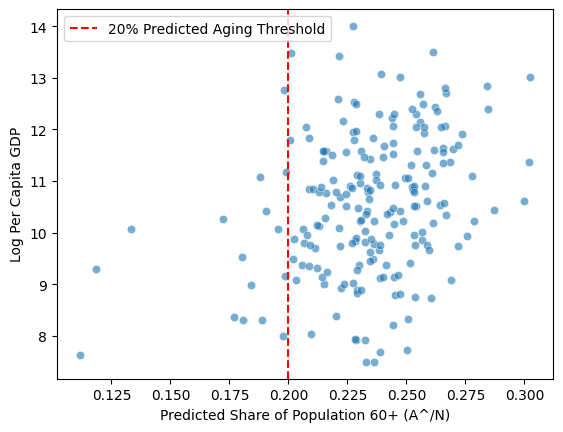

In [ ]:
sns.scatterplot(data=merged, x='A_hat_N', y='ln_GDP_N', alpha=0.6)
plt.axvline(cutoff, linestyle="--", color="red", label="20% Predicted Aging Threshold")
plt.xlabel("Predicted Share of Population 60+ (A^/N)")
plt.ylabel("Log Per Capita GDP")
plt.legend()
plt.show()

In [ ]:
print("First Stage F-Statistic:", first_stage.fvalue)

First Stage F-Statistic: 10.76205344020234
